In [14]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data
## Data Cleaning

In [15]:
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df.head()

/home/lei/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [16]:
#Check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

In [17]:
#drop columns that has data less than 60% (for INATTENTIONIND, PEDROWNOTGRNT and SPEEDING, we assume the empty value is N, so they are kept and values will be fixed)
df.drop(['INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC'], axis=1, inplace=True)

#drop id columns that doesn't help the data analysis
df.drop(['OBJECTID', 'INCKEY', 'COLDETKEY','REPORTNO','SDOTCOLNUM','ST_COLDESC'], axis=1, inplace=True)

#drop columns that represent duplicate information
df.drop(['LOCATION', 'SEVERITYDESC','SEVERITYCODE.1', 'SDOT_COLDESC','SEGLANEKEY','CROSSWALKKEY','INCDTTM'], axis=1, inplace=True)

#drop "status" column since it's not described in Meta-Data documentation(https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf), so the meaning of this column is unclear
df.drop(['STATUS'], axis=1, inplace=True)

In [18]:
#fix missing values in INATTENTIONIND, PEDROWNOTGRNT and SPEEDING by fillna with N
df[['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING']] = df[['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING']].fillna(value='N')

#UNDERINFL column has values N, 0 and 1, which will be fixed as N and 0 to be N and 1 to be Y
df.loc[df['UNDERINFL'] == '0', 'UNDERINFL'] = 'N'
df.loc[df['UNDERINFL'] == '1', 'UNDERINFL'] = 'Y'

#Add MONTH, DAYOFWEEK and HOUR columns from INCDTTM, and then drop INCDATE
df['MONTH'] = df.apply(lambda row: datetime.datetime.strptime(row['INCDATE'][0:10], '%Y/%m/%d').month, axis=1)
df['DAYOFWEEK'] = df.apply(lambda row: datetime.datetime.strptime(row['INCDATE'][0:10], '%Y/%m/%d').weekday(), axis=1)
df.drop(['INCDATE'], axis=1, inplace=True)

## Feature Selection
### Analysis distribution of each feature

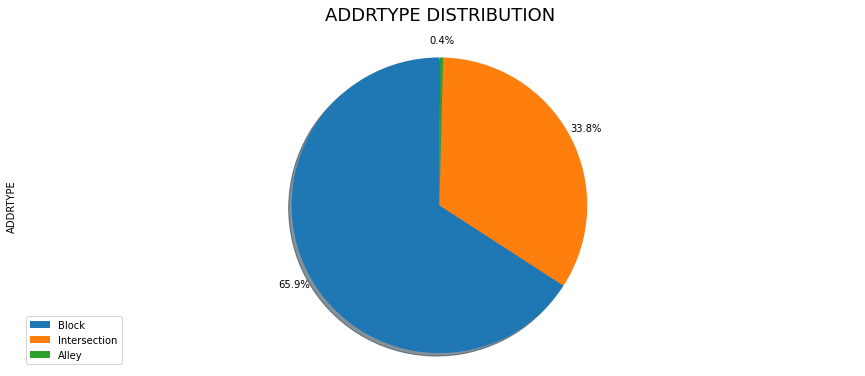

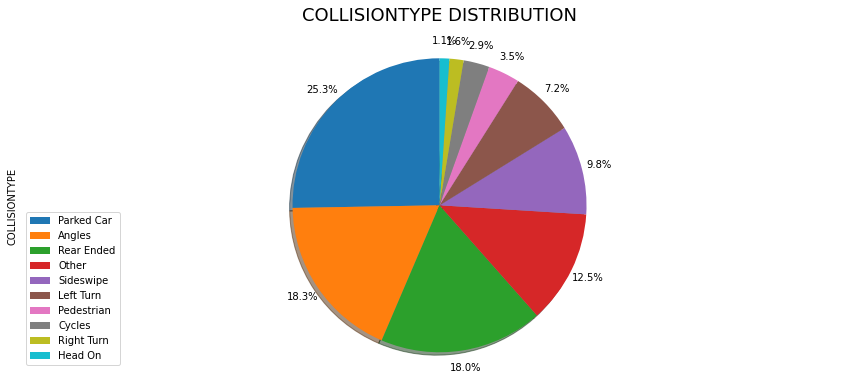

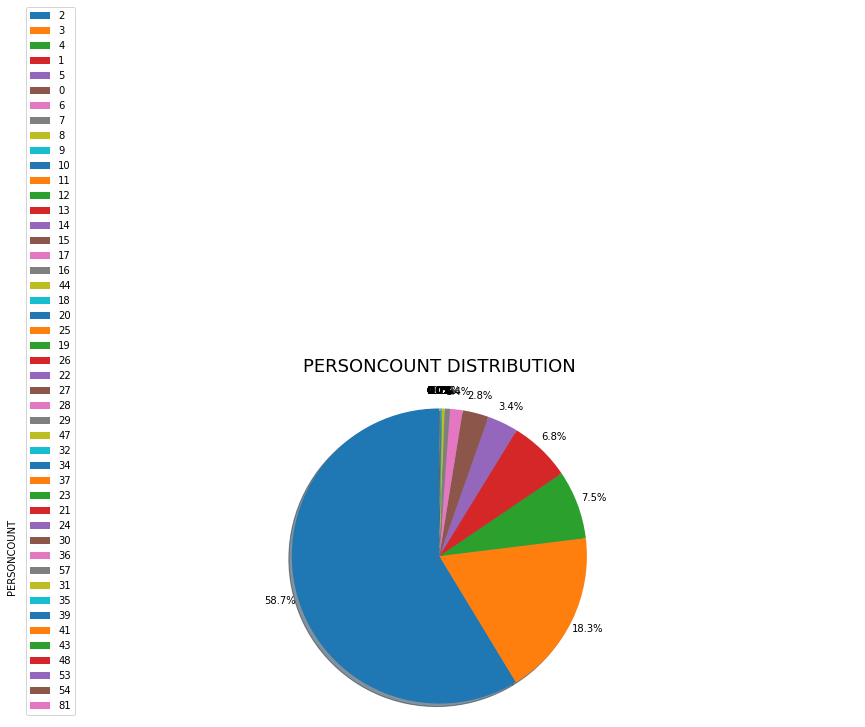

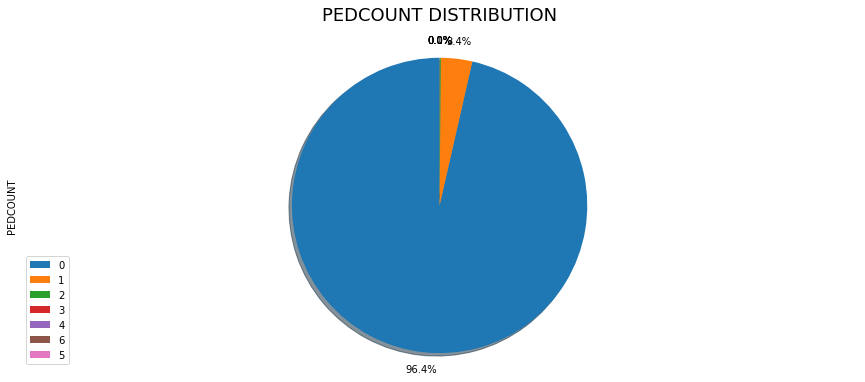

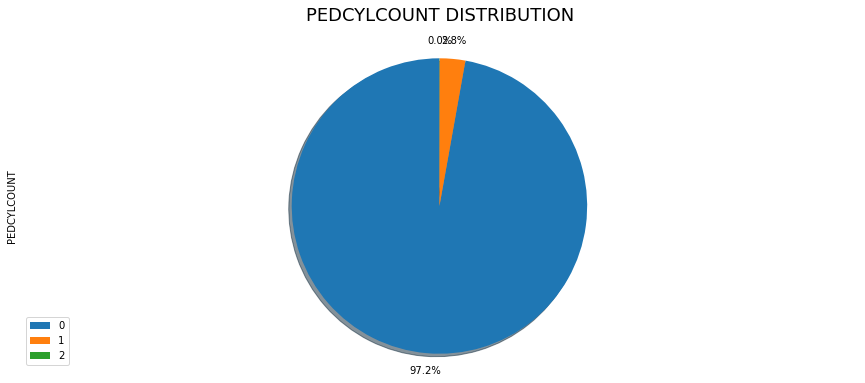

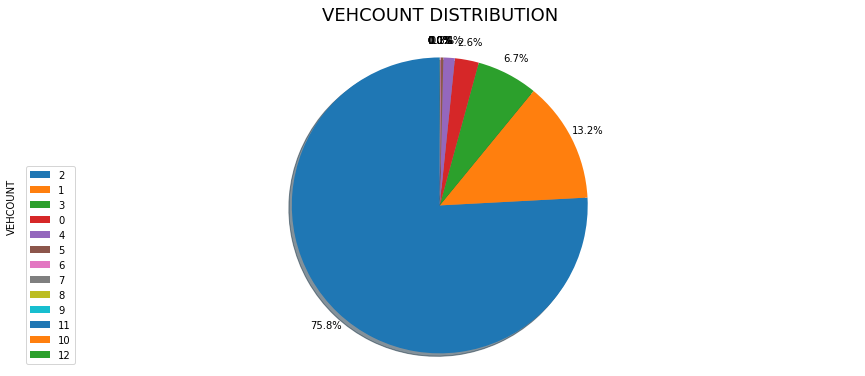

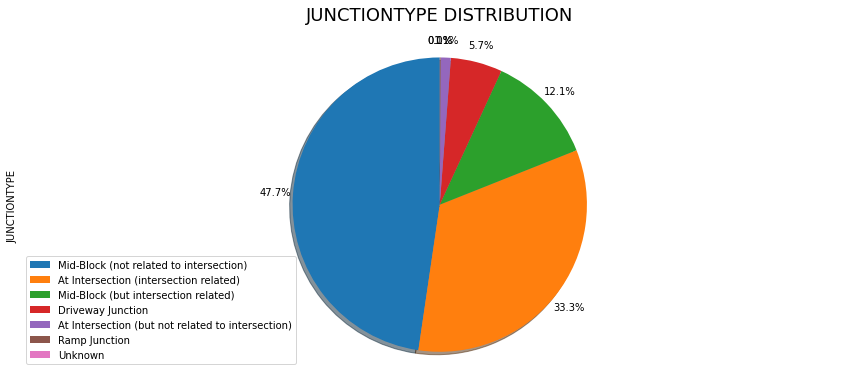

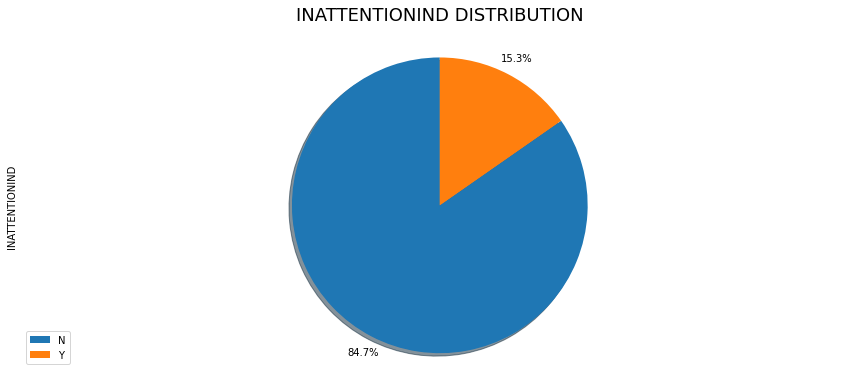

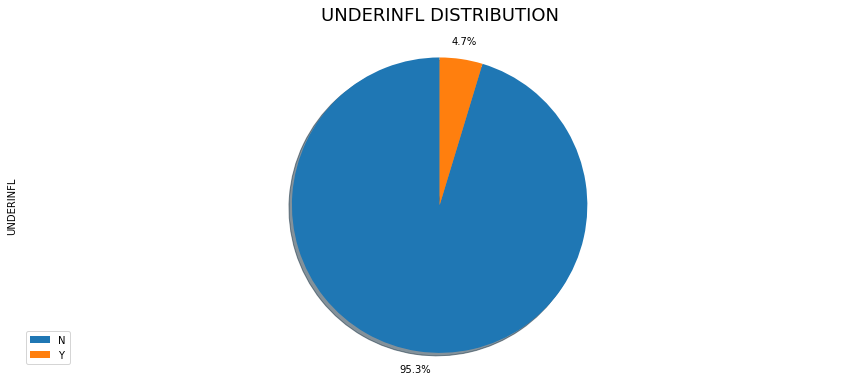

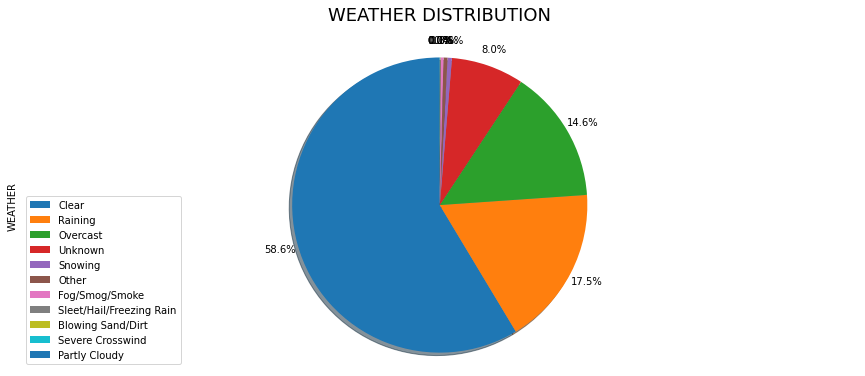

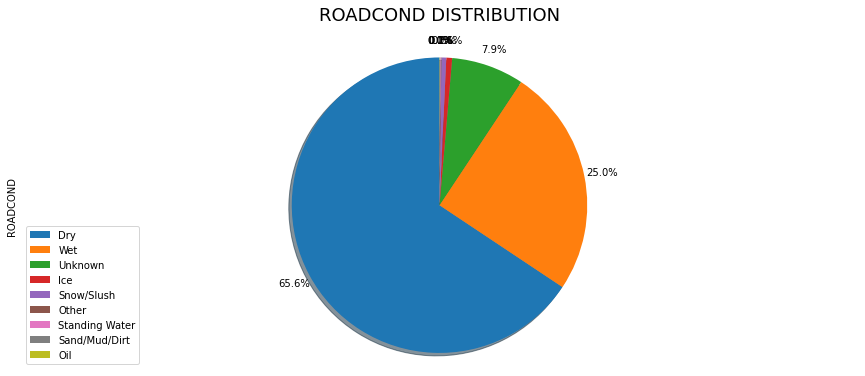

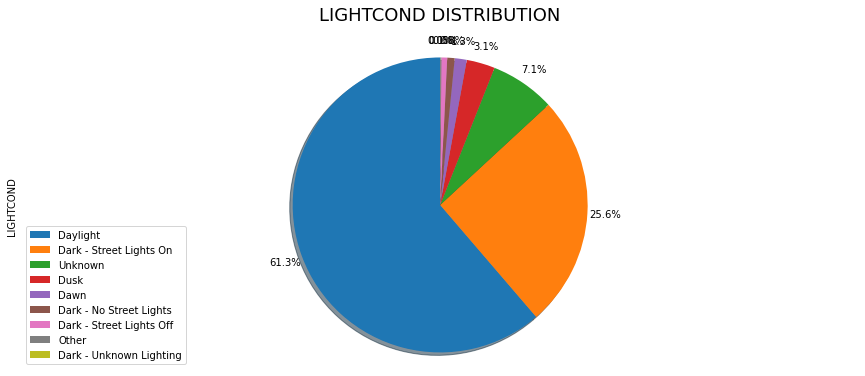

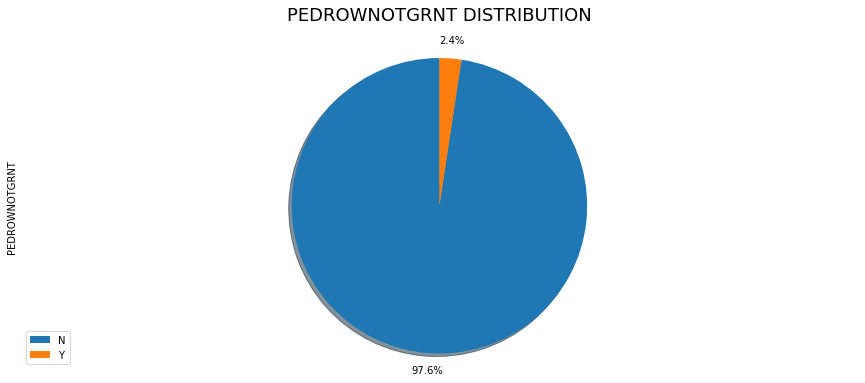

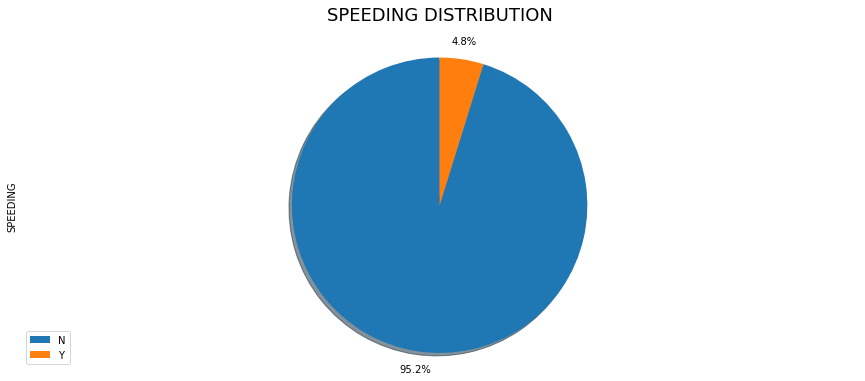

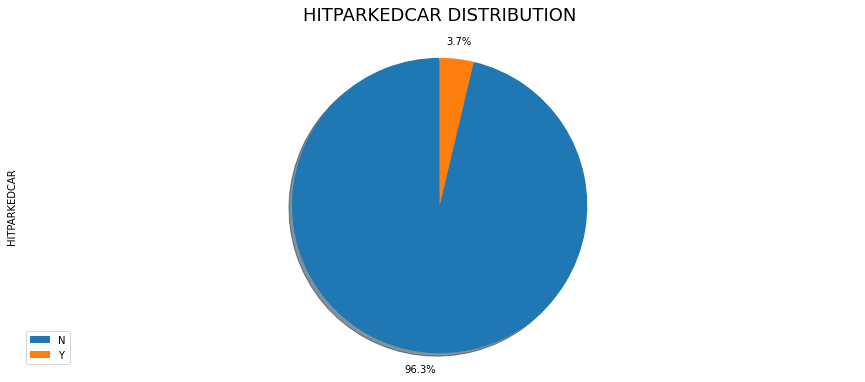

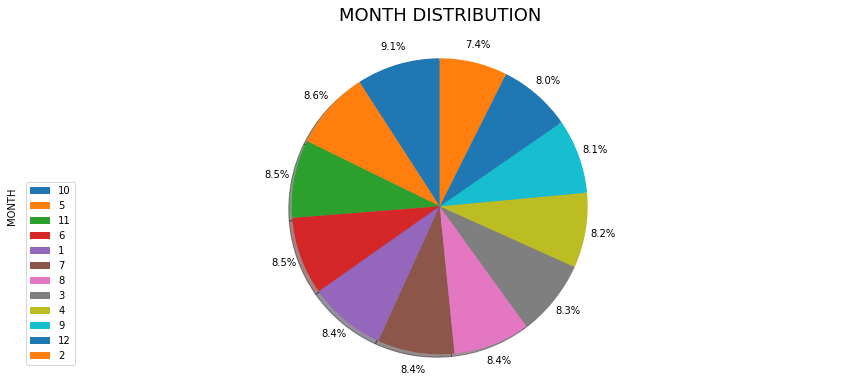

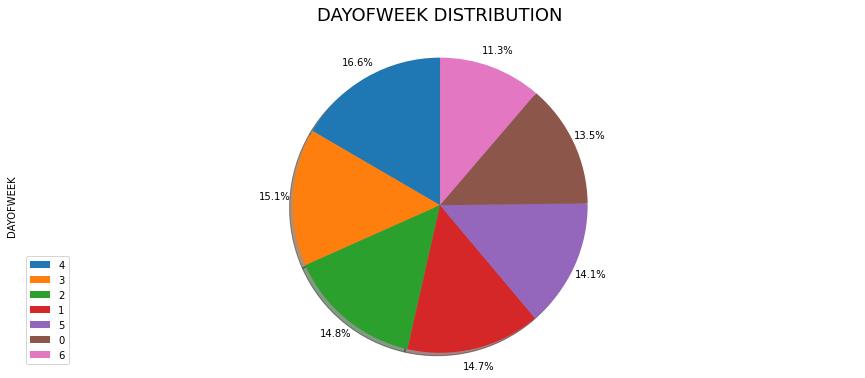

In [19]:
cols = ['ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','MONTH','DAYOFWEEK']
for col in cols:
    df_col = df[col].value_counts()
    df_col.plot(kind='pie',
            figsize=(15, 6),
            autopct='%1.1f%%',
            startangle=90,
            shadow=True,
            labels=None,
            pctdistance=1.12)
    plt.title(col + ' DISTRIBUTION', fontsize=18, y=1.05)
    plt.axis('equal')
    plt.legend(labels=df_col.index, loc='lower left')
    plt.show()

In [20]:
# Encoding SEVERITYCODE
df.loc[df['SEVERITYCODE'] == '2', 'SEVERITYCODE'] = 1
df.loc[df['SEVERITYCODE'] == '1', 'SEVERITYCODE'] = 0

# Encoding ADDRTYPE
df.loc[df['ADDRTYPE'] == 'Intersection', 'ADDRTYPE'] = 0
df.loc[df['ADDRTYPE'] == 'Block', 'ADDRTYPE'] = 1
df.loc[df['ADDRTYPE'] == 'Alley', 'ADDRTYPE'] = 2
df[['ADDRTYPE']] = df[['ADDRTYPE']].fillna(value = 3)

# Encoding COLLISIONTYPE
df.loc[df['COLLISIONTYPE'] == 'Angles', 'COLLISIONTYPE'] = 0
df.loc[df['COLLISIONTYPE'] == 'Sideswipe', 'COLLISIONTYPE'] = 1
df.loc[df['COLLISIONTYPE'] == 'Parked Car', 'COLLISIONTYPE'] = 2
df.loc[df['COLLISIONTYPE'] == 'Other', 'COLLISIONTYPE'] = 3
df.loc[df['COLLISIONTYPE'] == 'Cycles', 'COLLISIONTYPE'] = 4
df.loc[df['COLLISIONTYPE'] == 'Head On', 'COLLISIONTYPE'] = 5
df.loc[df['COLLISIONTYPE'] == 'Left Turn', 'COLLISIONTYPE'] = 6
df.loc[df['COLLISIONTYPE'] == 'Right Turn', 'COLLISIONTYPE'] = 7
df.loc[df['COLLISIONTYPE'] == 'Rear Ended', 'COLLISIONTYPE'] = 8
df.loc[df['COLLISIONTYPE'] == 'Pedestrian', 'COLLISIONTYPE'] = 9
df[['COLLISIONTYPE']] = df[['COLLISIONTYPE']].fillna(value = 10)

# Encoding JUNCTIONTYPE
df.loc[df['JUNCTIONTYPE'] == 'At Intersection (intersection related)', 'JUNCTIONTYPE'] = 0
df.loc[df['JUNCTIONTYPE'] == 'At Intersection (but not related to intersection)', 'JUNCTIONTYPE'] = 1
df.loc[df['JUNCTIONTYPE'] == 'Mid-Block (not related to intersection)', 'JUNCTIONTYPE'] = 2
df.loc[df['JUNCTIONTYPE'] == 'Mid-Block (but intersection related)', 'JUNCTIONTYPE'] = 3
df.loc[df['JUNCTIONTYPE'] == 'Driveway Junction', 'JUNCTIONTYPE'] = 4
df.loc[df['JUNCTIONTYPE'] == 'Ramp Junction', 'JUNCTIONTYPE'] = 4
df.loc[df['JUNCTIONTYPE'] == 'Unknown', 'JUNCTIONTYPE'] = 5
df[['JUNCTIONTYPE']] = df[['JUNCTIONTYPE']].fillna(value = 6)

# Encoding INATTENTIONIND
df.loc[df['INATTENTIONIND'] == 'Y', 'INATTENTIONIND'] = 1
df.loc[df['INATTENTIONIND'] == 'N', 'INATTENTIONIND'] = 0

# Encoding UNDERINFL
df.loc[df['UNDERINFL'] == 'Y', 'UNDERINFL'] = 1
df.loc[df['UNDERINFL'] == 'N', 'UNDERINFL'] = 0

# Encoding WEATHER
df.loc[df['WEATHER'] == 'Overcast', 'WEATHER'] = 0
df.loc[df['WEATHER'] == 'Raining', 'WEATHER'] = 1
df.loc[df['WEATHER'] == 'Clear', 'WEATHER'] = 2
df.loc[df['WEATHER'] == 'Snowing', 'WEATHER'] = 3
df.loc[df['WEATHER'] == 'Fog/Smog/Smoke', 'WEATHER'] = 4
df.loc[df['WEATHER'] == 'Sleet/Hail/Freezing Rain', 'WEATHER'] = 5
df.loc[df['WEATHER'] == 'Blowing Sand/Dirt', 'WEATHER'] = 6
df.loc[df['WEATHER'] == 'Severe Crosswind', 'WEATHER'] = 7
df.loc[df['WEATHER'] == 'Partly Cloudy', 'WEATHER'] = 8
df.loc[df['WEATHER'] == 'Other', 'WEATHER'] = 9
df.loc[df['WEATHER'] == 'Unknown', 'WEATHER'] = 10
df[['WEATHER']] = df[['WEATHER']].fillna(value = 11)

# Encoding ROADCOND
df.loc[df['ROADCOND'] == 'Wet', 'ROADCOND'] = 0
df.loc[df['ROADCOND'] == 'Dry', 'ROADCOND'] = 1
df.loc[df['ROADCOND'] == 'Snow/Slush', 'ROADCOND'] = 2
df.loc[df['ROADCOND'] == 'Ice', 'ROADCOND'] = 3
df.loc[df['ROADCOND'] == 'Sand/Mud/Dirt', 'ROADCOND'] = 4
df.loc[df['ROADCOND'] == 'Oil', 'ROADCOND'] = 5
df.loc[df['ROADCOND'] == 'Standing Water', 'ROADCOND'] = 6
df.loc[df['ROADCOND'] == 'Other', 'ROADCOND'] = 7
df.loc[df['ROADCOND'] == 'Unknown', 'ROADCOND'] = 8
df[['ROADCOND']] = df[['ROADCOND']].fillna(value = 9)

# Encoding LIGHTCOND
df.loc[df['LIGHTCOND'] == 'Daylight', 'LIGHTCOND'] = 0
df.loc[df['LIGHTCOND'] == 'Dark - Street Lights On', 'LIGHTCOND'] = 1
df.loc[df['LIGHTCOND'] == 'Dark - Street Lights Off', 'LIGHTCOND'] = 2
df.loc[df['LIGHTCOND'] == 'Dark - No Street Lights', 'LIGHTCOND'] = 3
df.loc[df['LIGHTCOND'] == 'Dusk', 'LIGHTCOND'] = 4
df.loc[df['LIGHTCOND'] == 'Dawn', 'LIGHTCOND'] = 5
df.loc[df['LIGHTCOND'] == 'Dark - Unknown Lighting', 'LIGHTCOND'] = 6
df.loc[df['LIGHTCOND'] == 'Other', 'LIGHTCOND'] = 7
df.loc[df['LIGHTCOND'] == 'Unknown', 'LIGHTCOND'] = 8
df[['LIGHTCOND']] = df[['LIGHTCOND']].fillna(value = 9)

# Encoding PEDROWNOTGRNT
df.loc[df['PEDROWNOTGRNT'] == 'Y', 'PEDROWNOTGRNT'] = 1
df.loc[df['PEDROWNOTGRNT'] == 'N', 'PEDROWNOTGRNT'] = 0

# Encoding SPEEDING
df.loc[df['SPEEDING'] == 'Y', 'SPEEDING'] = 1
df.loc[df['SPEEDING'] == 'N', 'SPEEDING'] = 0

# Encoding HITPARKEDCAR
df.loc[df['HITPARKEDCAR'] == 'Y', 'HITPARKEDCAR'] = 1
df.loc[df['HITPARKEDCAR'] == 'N', 'HITPARKEDCAR'] = 0

/home/lei/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/lei/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


### Get correlation between SEVERITYCODE and other features

In [21]:
df[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','MONTH','DAYOFWEEK']]\
.corr()['SEVERITYCODE'].sort_values(ascending=False)

SEVERITYCODE     1.000000
PEDCOUNT         0.246338
PEDCYLCOUNT      0.214218
COLLISIONTYPE    0.208529
PERSONCOUNT      0.130949
MONTH            0.004730
DAYOFWEEK       -0.015246
VEHCOUNT        -0.054686
LIGHTCOND       -0.139913
WEATHER         -0.146811
ROADCOND        -0.151747
JUNCTIONTYPE    -0.172874
ADDRTYPE        -0.196399
Name: SEVERITYCODE, dtype: float64

In [22]:
#drop low correlation features
df.drop(['INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'MONTH', 'DAYOFWEEK', 'VEHCOUNT'], axis=1, inplace=True)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score,f1_score

In [24]:
#ML Feature Sets
x=df[['ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','HITPARKEDCAR']].values
x= preprocessing.StandardScaler().fit(x).transform(x)
y=df[["SEVERITYCODE"]].values.ravel()

#Test/Train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

#Analysis Decision Tree hyperparameters
criterion = ['gini', 'entropy']
for c in criterion:
    for depth in range(1, 10):
        dt_model = DecisionTreeClassifier(criterion = c, max_depth = depth)
        dt_model.fit(x_train, y_train)
        dt_yhat = dt_model.predict(x_test)
        print("criterion={}, depth={}, f1_score={}, accuracy_score={}".format(c, depth, f1_score(y_test, dt_yhat, average='weighted'), accuracy_score(dt_yhat, y_test)))

criterion=gini, depth=1, f1_score=0.5754798171509922, accuracy_score=0.6992423269551817
criterion=gini, depth=2, f1_score=0.6413766211112303, accuracy_score=0.7276743290098883
criterion=gini, depth=3, f1_score=0.6828927064977215, accuracy_score=0.7477590856555798
criterion=gini, depth=4, f1_score=0.6828927064977215, accuracy_score=0.7477590856555798
criterion=gini, depth=5, f1_score=0.7221582014462363, accuracy_score=0.7518428149479902
criterion=gini, depth=6, f1_score=0.7175924659197509, accuracy_score=0.7526646975728779
criterion=gini, depth=7, f1_score=0.7226691928313449, accuracy_score=0.752947219725183
criterion=gini, depth=8, f1_score=0.7244037525757387, accuracy_score=0.7512264029793245
criterion=gini, depth=9, f1_score=0.7246284211731648, accuracy_score=0.750789777834853
criterion=entropy, depth=1, f1_score=0.5754798171509922, accuracy_score=0.6992423269551817
criterion=entropy, depth=2, f1_score=0.6413766211112303, accuracy_score=0.7276743290098883
criterion=entropy, depth=3, 

In [12]:
#Analysis Logistic Regression hyperparameters
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
regularization = [0.1, 0.01, 0.001]

for c in regularization:
    for solver in solvers:
        lr_model = LogisticRegression(C = c, solver = solver)
        lr_model.fit(x_train, y_train)
        lr_yhat = lr_model.predict(x_test)
        print('C={}, Solver={}, f1_score={}, accuracy_score={}'.format(c, solver, f1_score(y_test, lr_yhat, average='weighted'), accuracy_score(y_test, lr_yhat)))

C=0.1, Solver=lbfgs, f1_score=0.7029271021807496, accuracy_score=0.7455245922691666
C=0.1, Solver=saga, f1_score=0.7029271021807496, accuracy_score=0.7455245922691666
C=0.1, Solver=liblinear, f1_score=0.7029271021807496, accuracy_score=0.7455245922691666
C=0.1, Solver=newton-cg, f1_score=0.7029271021807496, accuracy_score=0.7455245922691666
C=0.1, Solver=sag, f1_score=0.7029271021807496, accuracy_score=0.7455245922691666
C=0.01, Solver=lbfgs, f1_score=0.7028914670953034, accuracy_score=0.7456016437652497
C=0.01, Solver=saga, f1_score=0.7028914670953034, accuracy_score=0.7456016437652497
C=0.01, Solver=liblinear, f1_score=0.7028304917308837, accuracy_score=0.7455245922691666
C=0.01, Solver=newton-cg, f1_score=0.7028914670953034, accuracy_score=0.7456016437652497
C=0.01, Solver=sag, f1_score=0.7028914670953034, accuracy_score=0.7456016437652497
C=0.001, Solver=lbfgs, f1_score=0.7011543804963457, accuracy_score=0.7466033132143316
C=0.001, Solver=saga, f1_score=0.7011543804963457, accuracy

/home/lei/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/lei/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/lei/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


C=0.001, Solver=newton-cg, f1_score=0.7011543804963457, accuracy_score=0.7466033132143316
C=0.001, Solver=sag, f1_score=0.7011543804963457, accuracy_score=0.7466033132143316


In [16]:
#Analysis KNN hyperparameter
for n in range(1, 20):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    knn_yhat = neigh.predict(x_test)
    print("n={}, f1_score={}, accuracy_score={}".format(n, f1_score(y_test, knn_yhat, average='weighted'), accuracy_score(y_test, knn_yhat)))

n=1, f1_score=0.6844532879623769, accuracy_score=0.6811609092076538
n=2, f1_score=0.6865701585619695, accuracy_score=0.7307050211891615
n=3, f1_score=0.7087412998375624, accuracy_score=0.7185052009759856
n=4, f1_score=0.7050176521303904, accuracy_score=0.7379992294850392
n=5, f1_score=0.7167796407909997, accuracy_score=0.7309875433414665
n=6, f1_score=0.7142603443333702, accuracy_score=0.7412867599845897
n=7, f1_score=0.7179227320928573, accuracy_score=0.7362784127391807
n=8, f1_score=0.7141339523457702, accuracy_score=0.7409528701682291
n=9, f1_score=0.7161943900862929, accuracy_score=0.7316810068062155
n=10, f1_score=0.7178106754291009, accuracy_score=0.7419288557852831
n=11, f1_score=0.7166244790728636, accuracy_score=0.7309618595094388
n=12, f1_score=0.7152278307980559, accuracy_score=0.740285090535508
n=13, f1_score=0.717025466815573, accuracy_score=0.7359702067548478
n=14, f1_score=0.7151558099943834, accuracy_score=0.7388724797739823
n=15, f1_score=0.7161821399113077, accuracy_s

In [13]:
#Analysis SVM hyperparameter
kernels = ['sigmoid', 'poly', 'rbf', 'linear']
for k in kernels:
    svc_model = SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(x_train, y_train)
    svc_yhat = svc_model.predict(x_test)
    print("kernel={}, f1_score={}, accuracy_score={}".format(k, f1_score(y_test, svc_yhat, average='weighted'), accuracy_score(svc_yhat, y_test)))

kernel=sigmoid, f1_score=0.6664069283040713, accuracy_score=0.6751252086811352
kernel=poly, f1_score=0.6842938042831762, accuracy_score=0.7484782329523565
kernel=rbf, f1_score=0.6883062944615758, accuracy_score=0.7489662257608836
kernel=linear, f1_score=0.6843390784776006, accuracy_score=0.7485039167843842


In [25]:
#Decision Tree final model
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
dt_model.fit(x_train, y_train)
dt_yhat = dt_model.predict(x_test)
dt_f1 = round(f1_score(y_test, dt_yhat, average = 'weighted'), 4)
dt_acc = round(accuracy_score(y_test, dt_yhat), 4)

#Logistic Regression final model
lr_model = LogisticRegression(C = 0.001, solver = 'newton-cg')
lr_model.fit(x_train, y_train)
lr_yhat = lr_model.predict(x_test)
lr_f1 = round(f1_score(y_test, lr_yhat, average = 'weighted'), 4)
lr_acc = round(accuracy_score(y_test, lr_yhat), 4)

#KNN final model
neigh = KNeighborsClassifier(n_neighbors = 10).fit(x_train,y_train)
knn_yhat = neigh.predict(x_test)
knn_f1 = round(f1_score(y_test, knn_yhat, average = 'weighted'), 4)
knn_acc = round(accuracy_score(y_test, knn_yhat), 4)

#SVM final model
svc_model = SVC(C = 0.01, gamma = 'auto', kernel = 'rbf')
svc_model.fit(x_train, y_train)
svc_yhat = svc_model.predict(x_test)
svc_f1 = round(f1_score(y_test, svc_yhat, average = 'weighted'), 4)
svc_acc = round(accuracy_score(y_test, svc_yhat), 4)

/home/lei/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/lei/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/lei/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [26]:
f1_list = [knn_f1, dt_f1, svc_f1, lr_f1]
acc_list = [knn_acc, dt_acc, svc_acc, lr_acc]
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['F1-score', 'acc_list']
df = pd.DataFrame([f1_list, acc_list], index = index, columns = columns)
df = df.transpose()
df.columns.name = 'Algorithm'
df

Algorithm,F1-score,acc_list
KNN,0.7178,0.7419
Decision Tree,0.7226,0.7530
SVM,0.6883,0.7490
Logistic Regression,0.7012,0.7466
